In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import kplr
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.signal import medfilt

import tensorflow as tf
session = tf.InteractiveSession()

from exoplanet import transit, kepler

import hemcee
import tfmodeling as tfm

import celeriteflow as cf

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
kepid = 11709124
client = kplr.API()
star = client.star(kepid)
t = []
y = []
yerr = []
quarter = []
texp = []
for i, lc in enumerate(star.get_light_curves(short_cadence=False)):
    with lc.open() as f:
        hdr = f[1].header
        texp0 = hdr["INT_TIME"] * hdr["NUM_FRM"] / (24. * 60. * 60.)
        data = f[1].data

    q = data["SAP_QUALITY"]
    t0 = data["TIME"]
    y0 = data["PDCSAP_FLUX"]
    m = (q == 0) & np.isfinite(t0) & np.isfinite(y0)
    mu = medfilt(y0[m], 101)
#     mu = np.median(y0[m])
    t.append(t0[m])
    y.append((y0[m] / mu - 1.0) * 1e3)
    yerr.append(data["PDCSAP_FLUX_ERR"][m] * 1e3 / mu)
    quarter.append(i + np.zeros(m.sum(), dtype=int))
    texp.append(texp0 + np.zeros(m.sum()))
t = np.ascontiguousarray(np.concatenate(t), dtype=np.float64)
y = np.ascontiguousarray(np.concatenate(y), dtype=np.float64)
yerr = np.ascontiguousarray(np.concatenate(yerr), dtype=np.float64)
quarter = np.ascontiguousarray(np.concatenate(quarter), dtype=int)
texp = np.ascontiguousarray(np.concatenate(texp), dtype=np.float64)

In [3]:
kois = star.kois
spec = np.empty(len(kois),
                dtype=[("period", float), ("ror", float), ("t0", float)])
for i, koi in enumerate(kois):
    spec["period"][i] = koi.koi_period
    spec["ror"][i] = koi.koi_ror
    spec["t0"][i] = koi.koi_time0bk % koi.koi_period
spec = spec[np.argsort(spec["period"])]

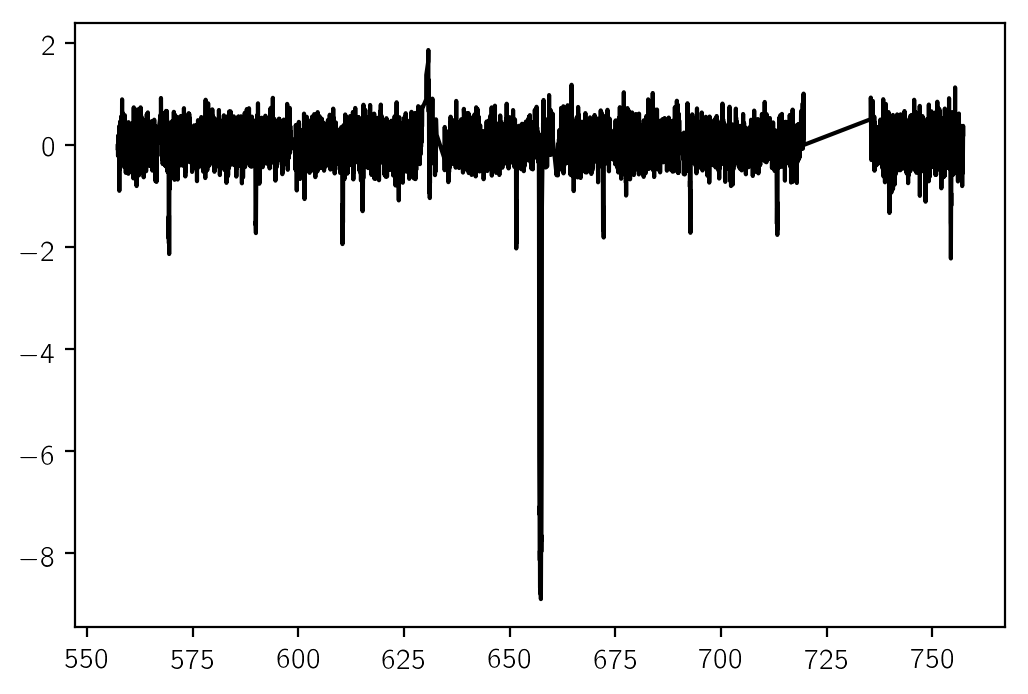

In [4]:
t0 = spec["t0"][-1]
rng = (t0 - 100 < t) & (t < t0 + 100)
plt.plot(t[rng], y[rng], "k")

In [5]:
gkf = Table.read("kepler_dr2_1arcsec.fits", format="fits").to_pandas()
star = gkf[gkf.kepid.astype(int) == kepid].iloc[0]

vals = dict()
for k in ["radius", "mass"]:
    mn = star[k] + star[k + "_err2"]
    mx = star[k] + star[k + "_err1"]
    log_mu = np.log(star[k])
    log_err = 0.5 * ((log_mu - np.log(mn)) + (np.log(mx) - log_mu))
    vals[k] = (log_mu, log_err)

np.random.seed(42)
N = 50000
R = np.exp(vals["radius"][0] + vals["radius"][1] * np.random.randn(N))
M = np.exp(vals["mass"][0] + vals["mass"][1] * np.random.randn(N))
log_dens = np.log(0.75 * M / (np.pi * R**3))
log_dens = (np.mean(log_dens), np.std(log_dens))
print(log_dens)

(-1.4547524087769572, 0.3502230916468015)


In [6]:
spec

array([(  3.93276627, 0.014124,   0.93558682),
       (  9.91937693, 0.012428,   7.92170991),
       ( 20.5498184 , 0.038064,  14.5478488 ),
       ( 33.0405509 , 0.022276,  29.0592564 ),
       ( 62.3026877 , 0.028719,  54.4941046 ),
       (934.09418462, 0.086844, 657.26877   )],
      dtype=[('period', '<f8'), ('ror', '<f8'), ('t0', '<f8')])

In [8]:
T = tf.float64

G_grav = 2945.462538537765
factor = (G_grav / (3 * np.pi)) ** (1./3)

nint = 3
dt = tf.constant(texp[rng][:, None] * np.linspace(-0.5, 0.5, 2*nint+1)[1:-1:2], dtype=T)
tmid_tensor = tf.constant(t[rng], dtype=T)
t_tensor = tmid_tensor[:, None] + dt
y_tensor = tf.constant(y[rng], dtype=T)
yerr_tensor = tf.constant(yerr[rng], dtype=T)

# Star
log_jitter = tfm.Parameter(
    2.0*np.log(np.median(yerr)),
    bounds=(2.0*np.log(0.01*np.median(yerr)), 2.0*np.log(10.0*np.median(yerr))),
    dtype=T)
flux = tfm.Parameter(0.0, bounds=(-2, 2), dtype=T)
q = tfm.Parameter(0.5 + np.zeros(2), bounds=(0, 1), dtype=T)
log_rho_star = tfm.Parameter(log_dens[0], dtype=T)
q1 = q.value[0]
q2 = q.value[1]
c1 = 2.0 * tf.sqrt(q1) * q2
c2 = tf.sqrt(q1) * (1.0 - 2.0 * q2)
ld = transit.QuadraticLimbDarkening(c1, c2)

# planets
pls = [2, 5]
n_pl = len(pls)
log_Ps = []
for p in spec["period"][pls]:
    bounds = None
#     bounds = (np.log(p - 1), np.log(p + 1))
#     if p > 365:
#         bounds = (np.log(10), np.log(100*365.))
    log_Ps.append(tfm.Parameter(np.log(p), bounds=bounds, dtype=T))
log_P = tf.stack([p.value for p in log_Ps])

log_r = tfm.Parameter(np.log(spec["ror"][pls]), dtype=T)  # bounds=(-10, 10), dtype=T)
t0 = tfm.Parameter(spec["t0"][pls], dtype=T)
b = tfm.Parameter(np.zeros(n_pl), bounds=(-2.0, 2.0), dtype=T)
e = tfm.Parameter(np.random.uniform(0, 0.01, n_pl), bounds=(0, 1.0), dtype=T)
# e = tfm.Parameter(np.zeros(n_pl), dtype=T)
omega_vec = tfm.UnitVector(np.random.randn(n_pl, 2), dtype=T)

ror = tf.exp(log_r.value)
a = factor * tf.exp((2.0 * log_P + log_rho_star.value) / 3.0)
cosi = tf.abs(b.value) / a
incl = tf.acos(cosi)

sin_omega = omega_vec.value[:, 0]
cos_omega = omega_vec.value[:, 1]
omega = tf.atan2(sin_omega, cos_omega)

print(kepler.sky_position(tf.exp(log_P), t0.value, e.value, omega, incl, t_tensor).shape)
coords = a[None, :, None, None] * kepler.sky_position(tf.exp(log_P), t0.value, e.value, omega, incl, t_tensor)
d = tf.sqrt(tf.reduce_sum(tf.square(coords[:2]), axis=0))
delta = transit.transit_depth(ld, d, ror[:, None, None]+tf.zeros_like(d), direction=coords[2], n_integrate=100)

transit_model = flux.value - 1e3 * tf.reduce_mean(tf.reduce_sum(delta, axis=0), axis=1)

err2 = tf.square(yerr_tensor) + tf.exp(log_jitter.value)
chi2 = tf.reduce_sum(tf.square(transit_model - y_tensor) / err2 + tf.log(err2))
chi2 += tf.square((log_rho_star.value - log_dens[0]) / log_dens[1])

log_prob = -0.5*chi2

# Beta prior
alpha = 0.867
beta = 3.03
log_prob += tf.reduce_sum((alpha-1)*tf.log(e.value) + (beta-1)*tf.log(1-e.value))

params = [flux, log_jitter, q, log_rho_star] + log_Ps + [log_r, t0, b, e, omega_vec]
model = tfm.Model(log_prob, params, session=session)

opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, model.get_parameters())

session.run(tf.global_variables_initializer())

(None, slice(None, None, None), slice(None, None, None))
(slice(None, None, None), None, None)
(3, 2, 7157, 3)
(None, slice(None, None, None), slice(None, None, None))
(slice(None, None, None), None, None)
Instructions for updating:
Use the retry module or similar alternatives.


Instructions for updating:
Use the retry module or similar alternatives.


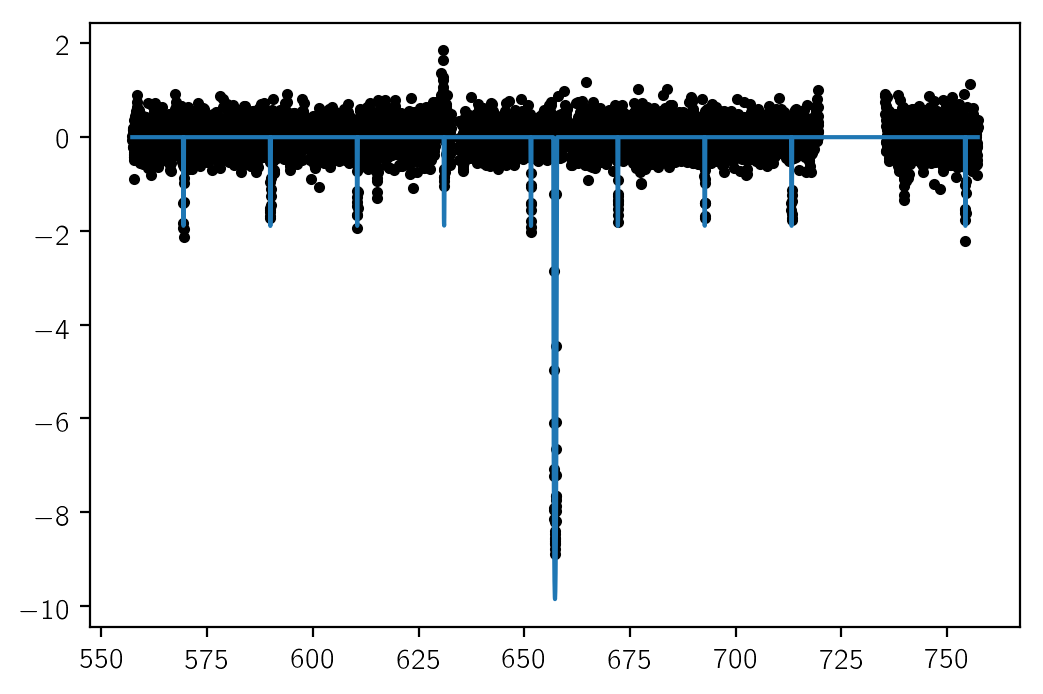

In [9]:
plt.plot(t[rng], y[rng], ".k")
plt.plot(tmid_tensor.eval(), transit_model.eval())

In [10]:
opt.minimize(session)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -10381.330481
  Number of iterations: 96
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -10381.330481
  Number of iterations: 96
  Number of functions evaluations: 122


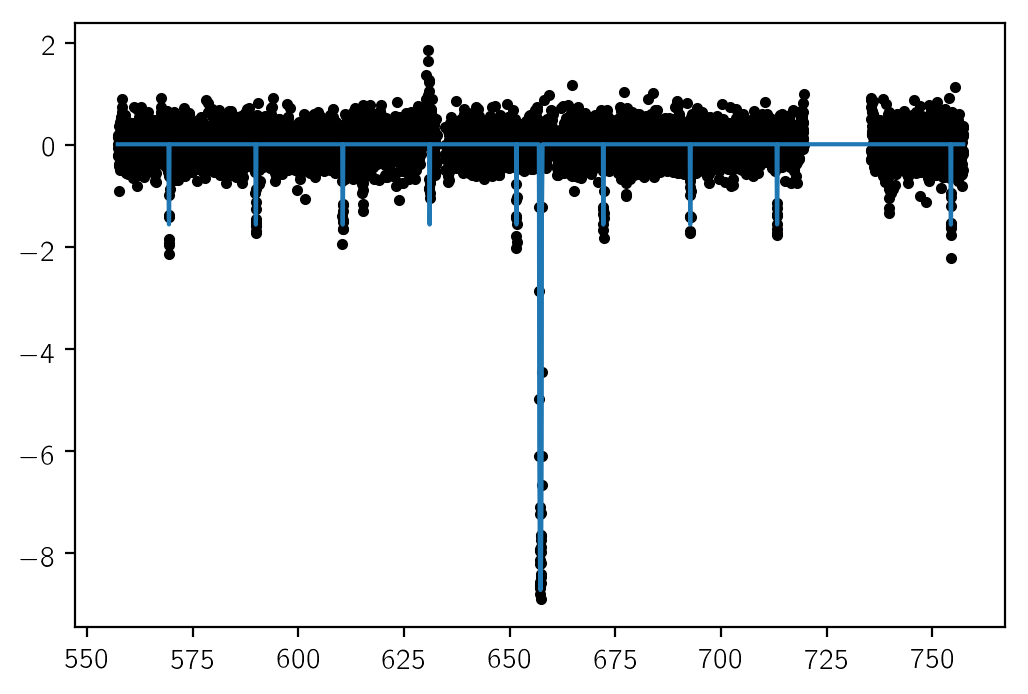

In [11]:
plt.plot(t[rng], y[rng], ".k")
plt.plot(tmid_tensor.eval(), transit_model.eval())

In [12]:
e.eval()

array([0.00253761, 0.00482155])

In [13]:
coords = model.current_vector()
ndim = len(coords)
print(ndim)

diag = np.empty(ndim)

eps = 1.234e-4
v0 = model.value(coords)
for n in range(ndim):
    coords[n] += eps
    vp = model.value(coords)
    coords[n] -= 2*eps
    vm = model.value(coords)
    coords[n] += eps
    
    diag[n] = eps**2 / np.abs(vp + vm - 2*v0)

19


In [23]:
diag

array([9.91408146e-04, 6.06240605e-02, 2.21393445e+03, 1.67212861e-02,
       1.70171611e-04, 1.70417846e-04, 1.11099668e-05, 1.98057117e-06,
       5.96923486e-02, 5.41697221e-01, 9.12940414e-02, 3.96481167e-01])

In [24]:
model.value(coords)
%timeit model.value(coords)

1000 loops, best of 3: 947 µs per loop


In [25]:
model.gradient(coords)
%timeit model.gradient(coords)

1000 loops, best of 3: 1.82 ms per loop


In [26]:
metric = hemcee.metric.DenseMetric(np.diag(diag))
sampler = hemcee.NoUTurnSampler(model.value, model.gradient, metric=metric)
results = sampler.run_warmup(coords, 10000, initial_buffer=1000, final_buffer=1000)

initial warm up: step_size: 1.4e-02; mean(accept_stat): 0.492: 100%|██████████| 1000/1000 [01:16<00:00, 12.37it/s]
warm up 1/9: step_size: 1.1e-02; mean(accept_stat): 0.517: 100%|██████████| 25/25 [00:02<00:00, 12.09it/s]
warm up 2/9: step_size: 2.3e-01; mean(accept_stat): 0.453: 100%|██████████| 25/25 [00:01<00:00, 18.97it/s]
warm up 3/9: step_size: 1.7e-01; mean(accept_stat): 0.471: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s]
warm up 4/9: step_size: 2.0e-01; mean(accept_stat): 0.483: 100%|██████████| 100/100 [00:06<00:00, 15.31it/s]
warm up 5/9: step_size: 2.0e-01; mean(accept_stat): 0.491: 100%|██████████| 200/200 [00:13<00:00, 14.50it/s]
warm up 6/9: step_size: 7.4e-02; mean(accept_stat): 0.493: 100%|██████████| 400/400 [00:28<00:00, 13.97it/s]
warm up 7/9: step_size: 5.0e-02; mean(accept_stat): 0.494: 100%|██████████| 800/800 [01:03<00:00, 13.58it/s]
warm up 8/9: step_size: 2.5e-02; mean(accept_stat): 0.495: 100%|██████████| 1600/1600 [02:11<00:00, 10.62it/s]
warm up 9/9: step

In [27]:
chain, lp_chain = sampler.run_mcmc(results[0], 5000)

step_size: 6.5e-02; mean(accept_stat): 0.390: 100%|██████████| 5000/5000 [06:07<00:00, 13.61it/s]


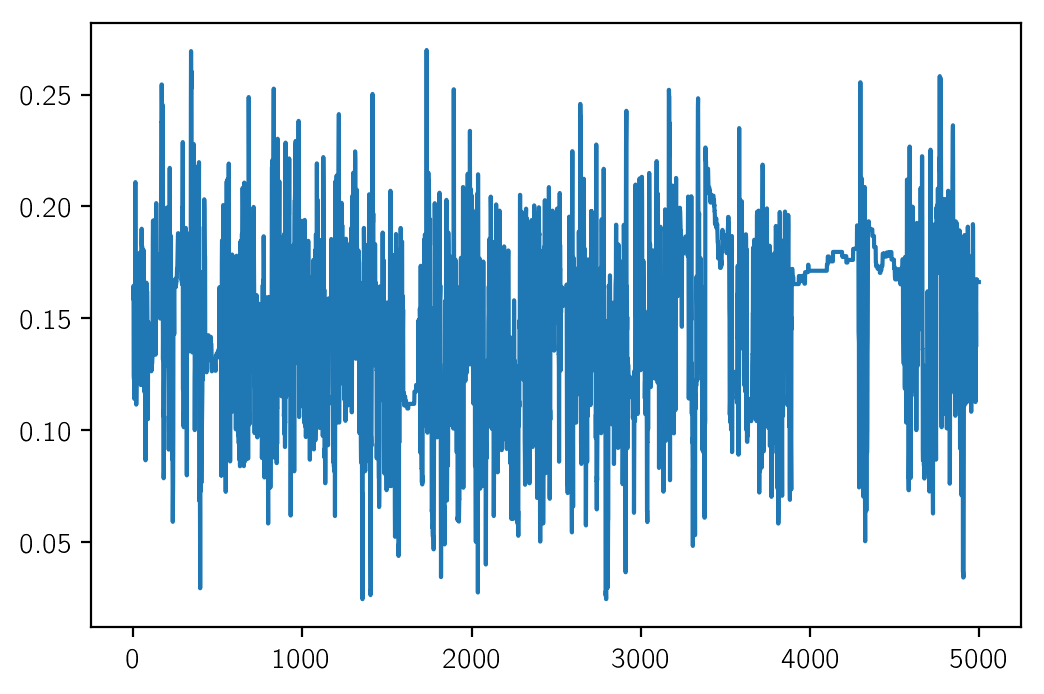

In [28]:
plt.plot(chain[:, 0]);

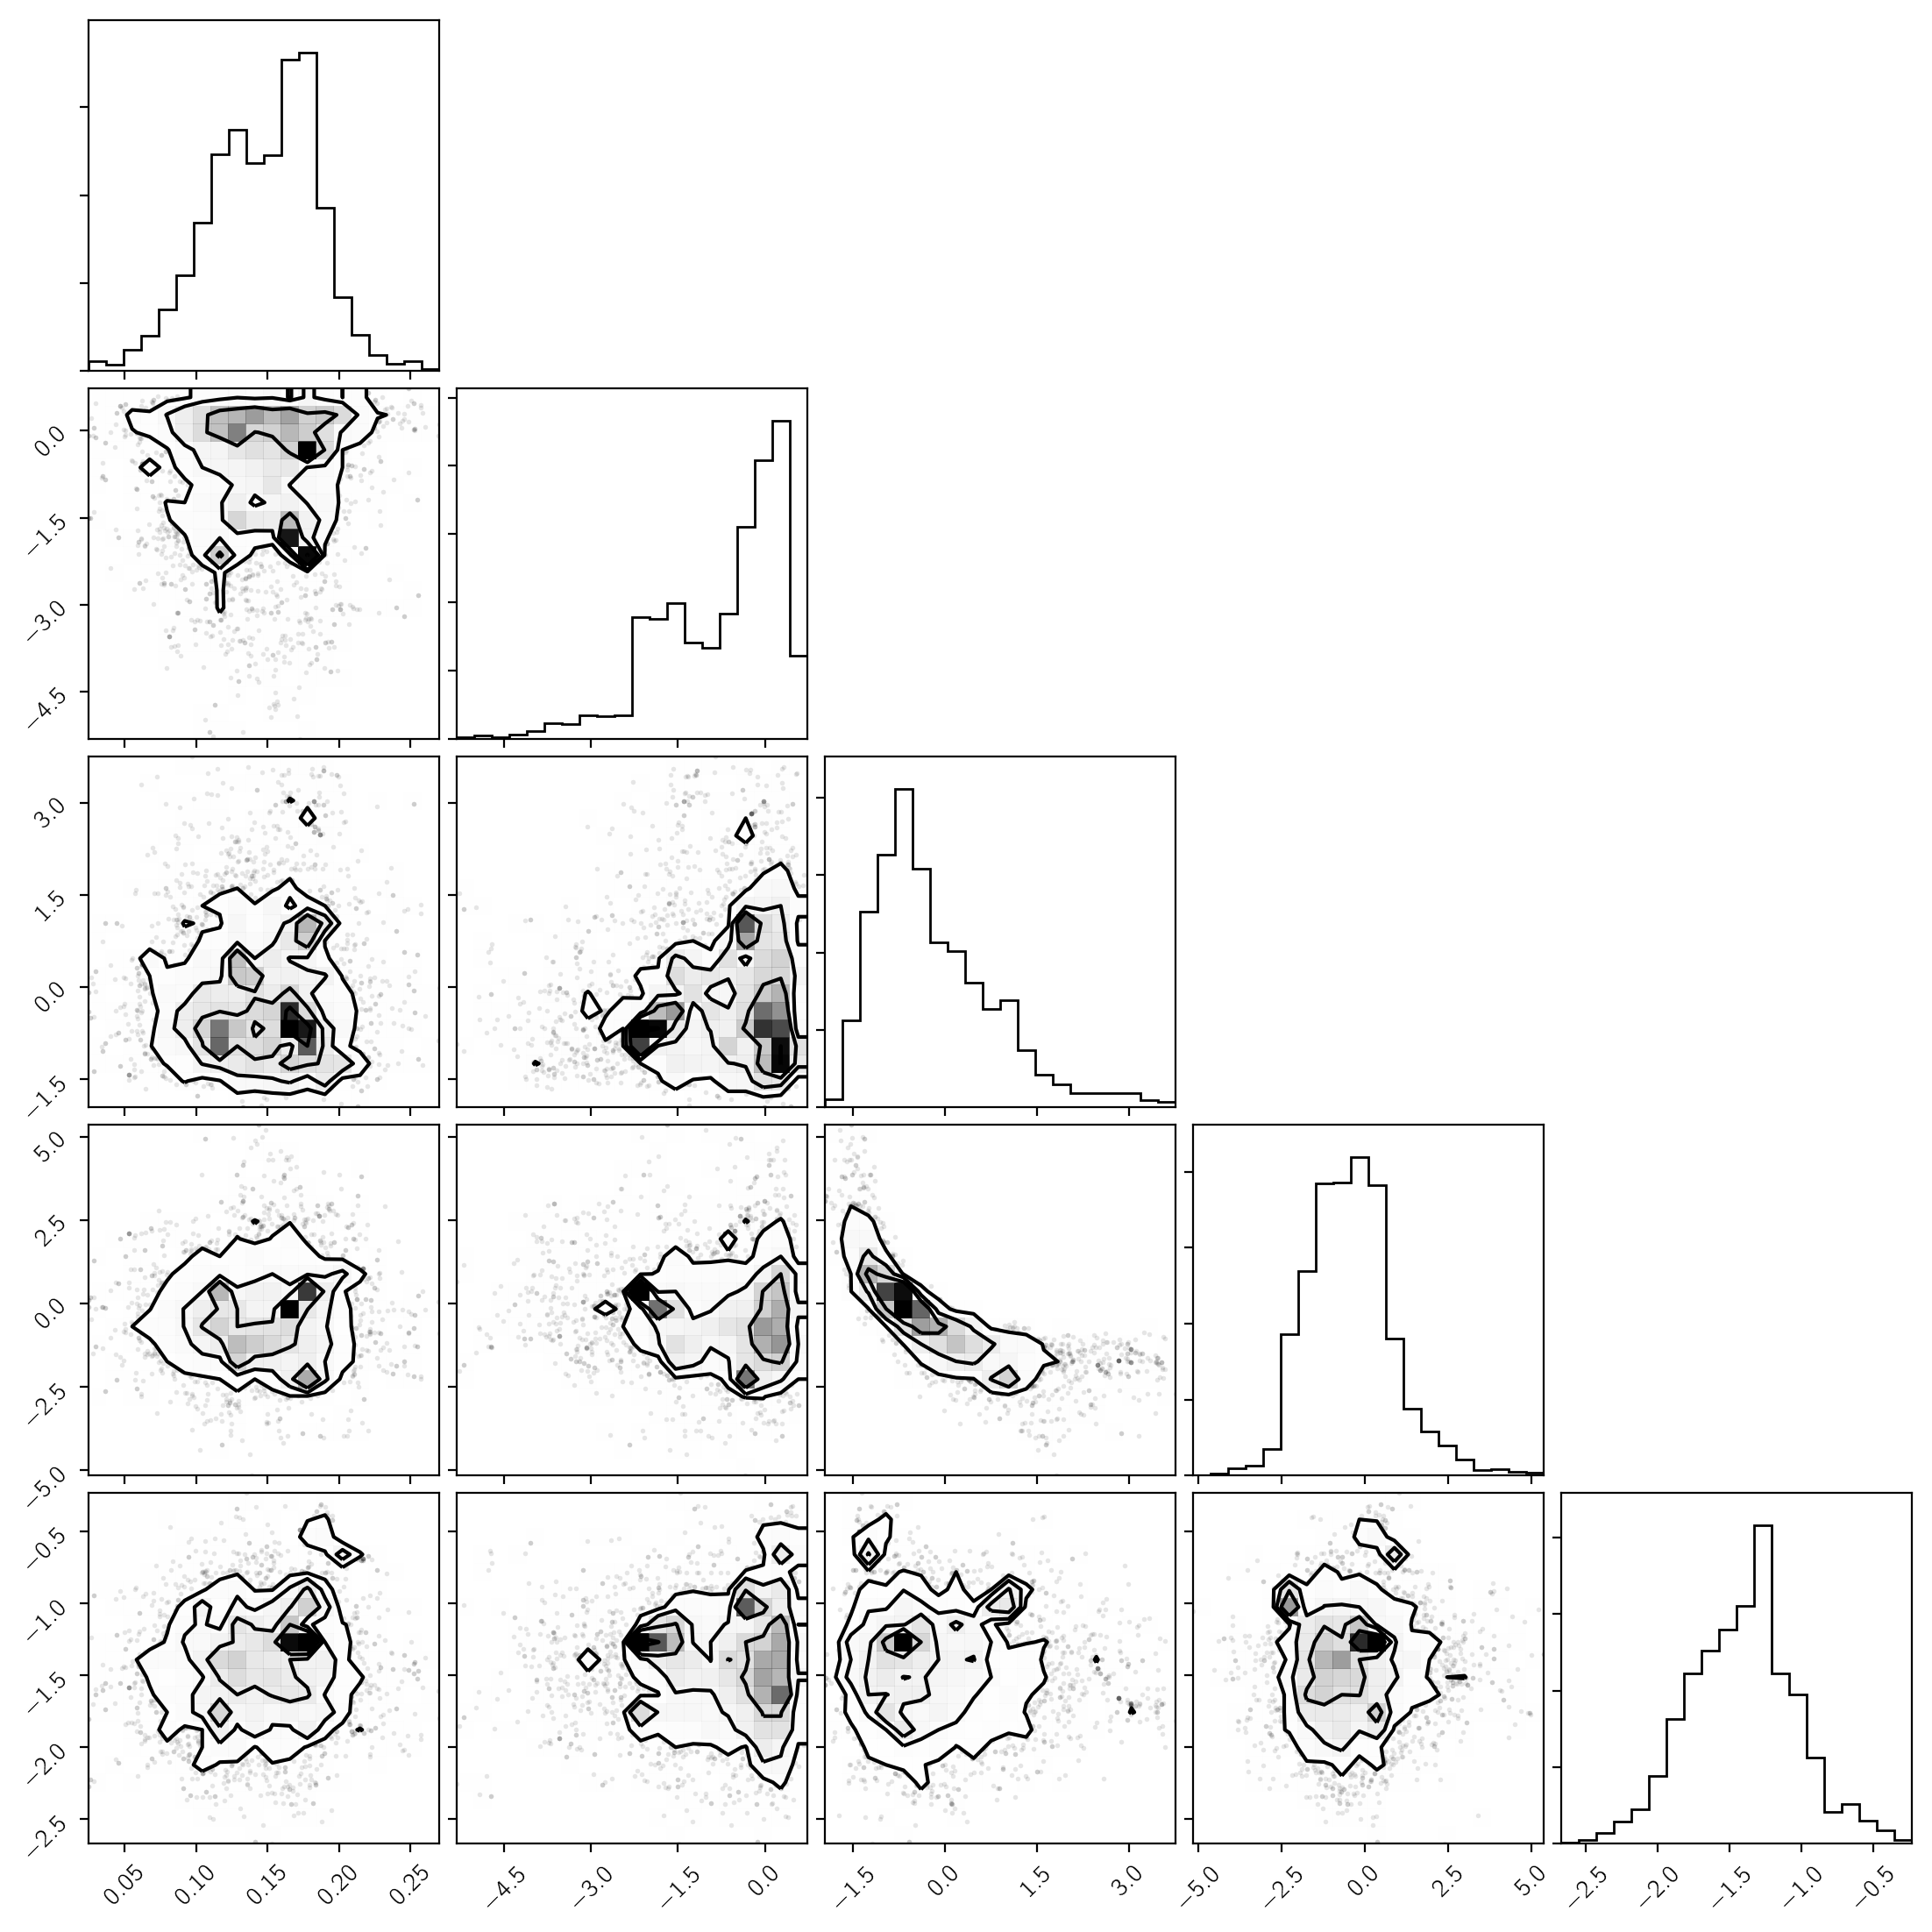

In [29]:
import corner
corner.corner(chain[:, :5]);

In [30]:
res = model.get_values_for_chain(chain, [log_rho_star.value], names=["log_rho"])

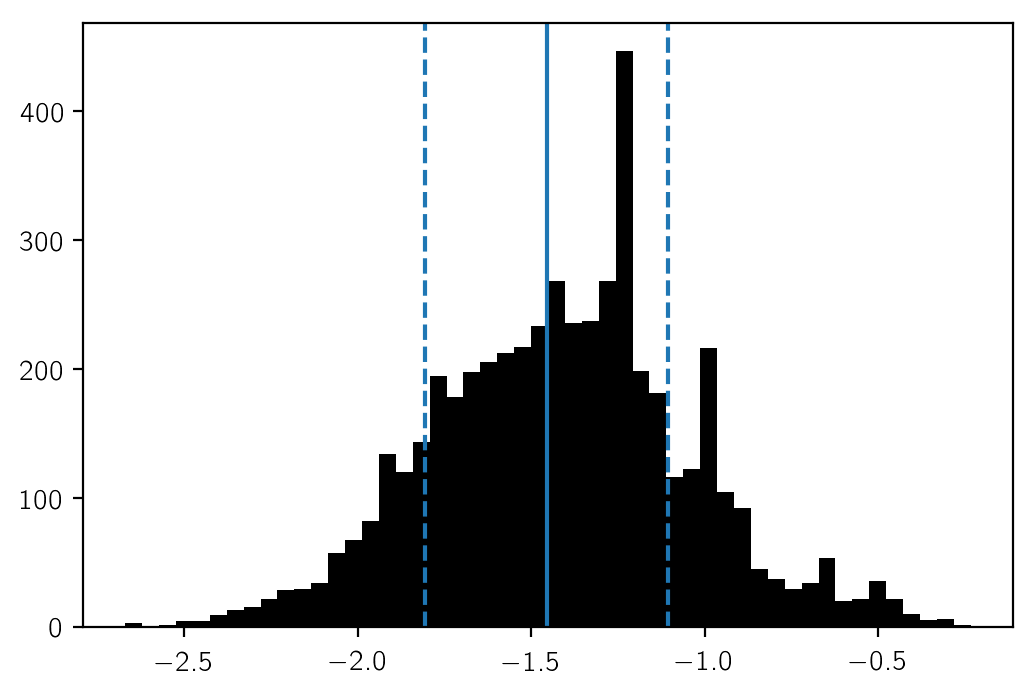

In [31]:
plt.hist(res["log_rho"], 50, color="k")
plt.axvline(log_dens[0])
plt.axvline(log_dens[0] + log_dens[1], linestyle="--")
plt.axvline(log_dens[0] - log_dens[1], linestyle="--");

In [38]:
res = model.get_values_for_chain(chain, [tf.exp(log_P)], names=["period"])

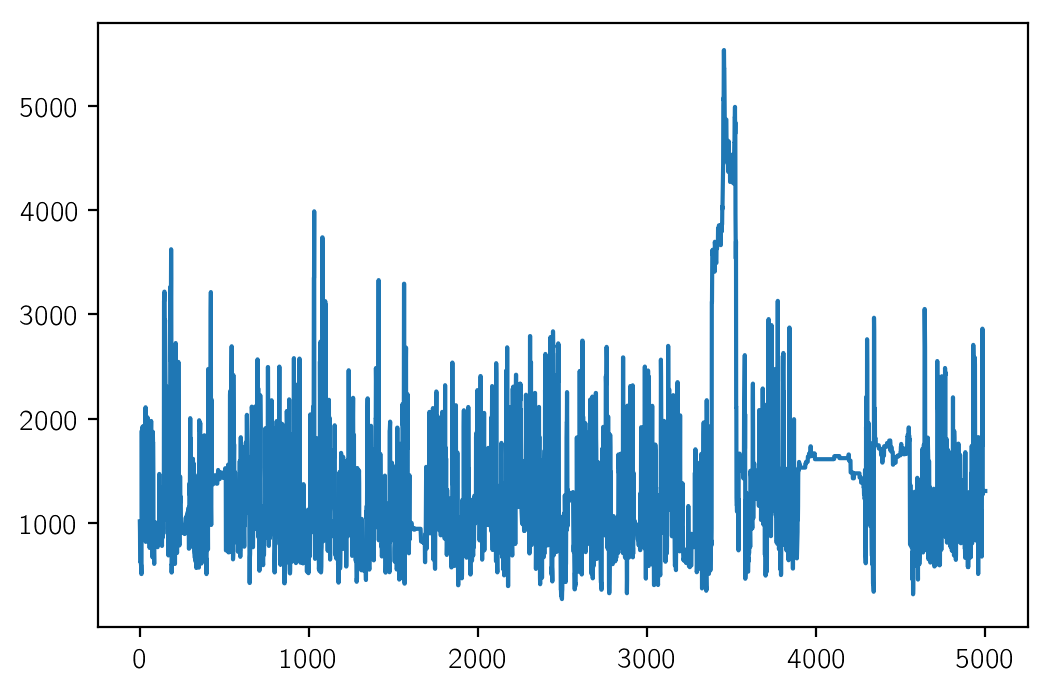

In [39]:
plt.plot(res["period"][:, 0])

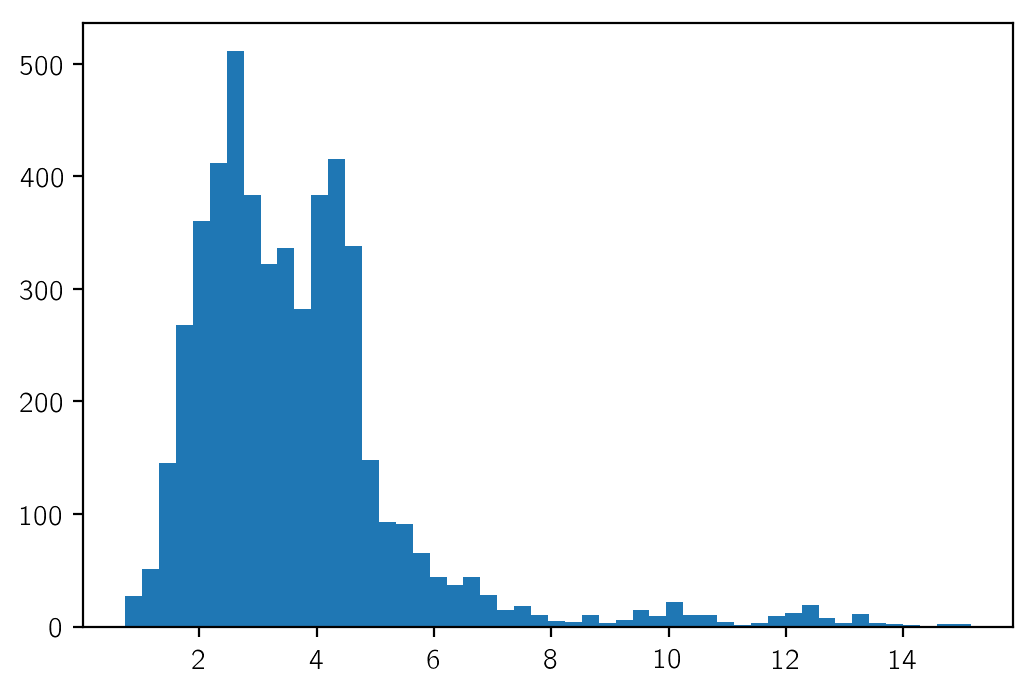

In [40]:
plt.hist(res["period"][:, -1] / 365.25, 50);

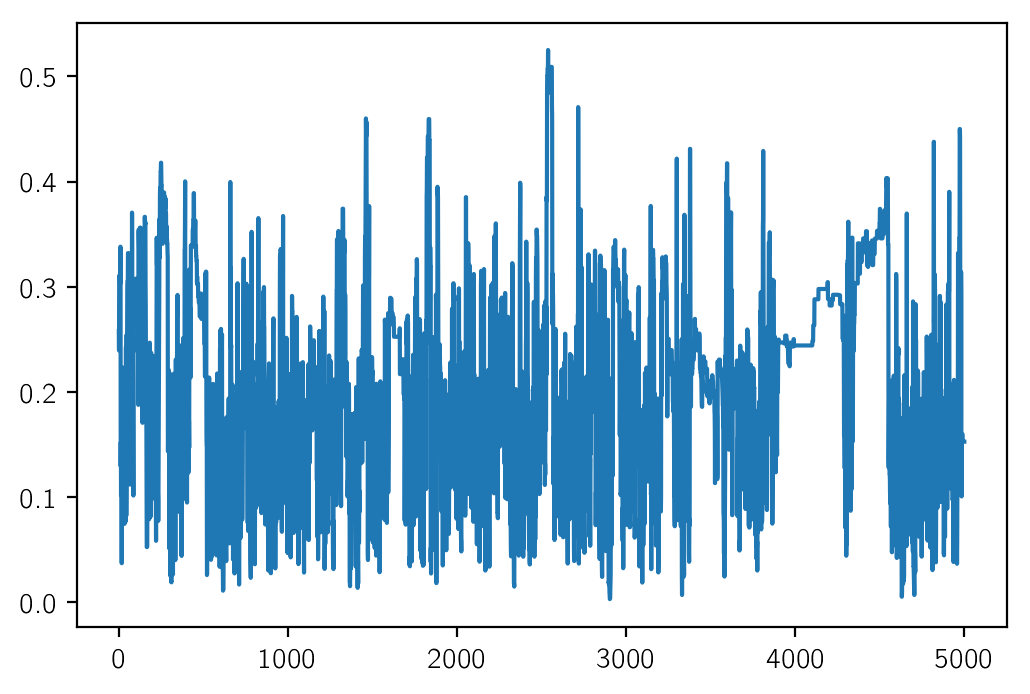

In [36]:
res = model.get_values_for_chain(chain, [e.value], names=["e"])
plt.plot(np.sqrt(res["e"]));

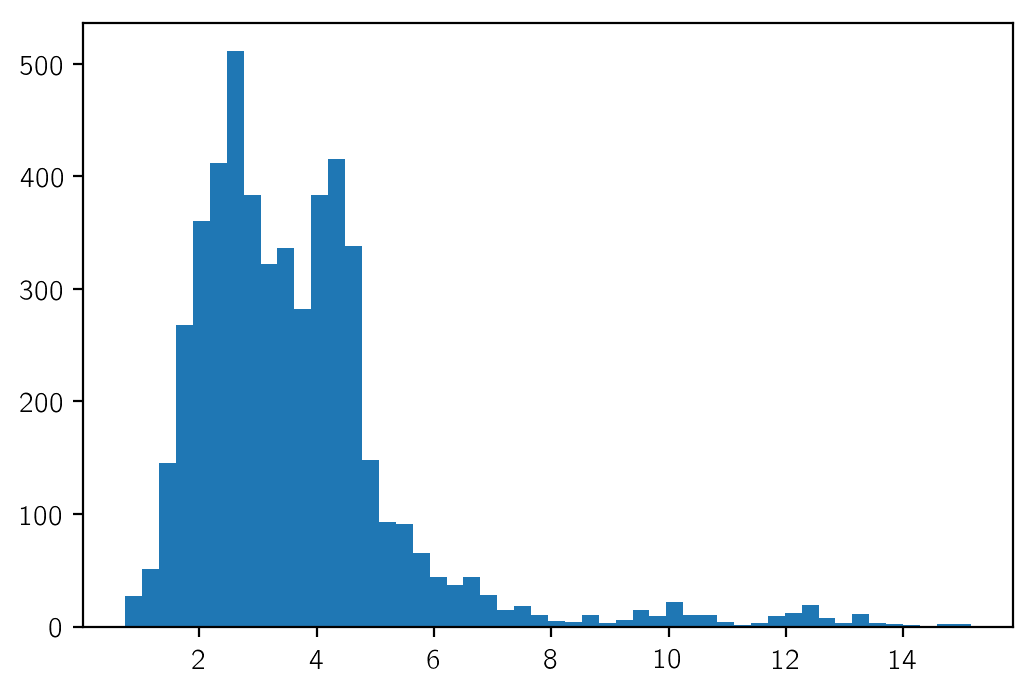

In [41]:
plt.hist(res["period"] / 365.25, 50);